**Approximation of Entropy based on Gaussian Distribution**

- author: Longfei Fan
- created: 05/24/2017
- modified: 08/07/2017

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.stats import poisson
from scipy.special import erfc

from qutip import *
import laser, entropy_utils

%matplotlib inline
%reload_ext autoreload
%autoreload 1
%aimport laser, entropy_utils

In [3]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')

**helpers**

In [4]:
def plot_n_vs_t(filename, xlim, ylim):
    n1_df = pd.read_csv(filename)
    entropy_utils.df_plot(n1_df, xlim=xlim, ylim=ylim, \
                          style = ['-', '-.', ':', '--'], \
                          xlabel=r'$gt$', ylabel=r'$\bar{n}$ (mean photon number)')
    plt.title(r'Evolution of $\bar{n}$ under Different $A/C$', fontsize=14);
    
    
def plot_entr_vs_t(filename, xlim, ylim):
    entr1_df = pd.read_csv(filename)
    entropy_utils.df_plot(entr1_df, xlim=xlim, ylim=ylim, \
                          xlabel=r'$gt$', ylabel=r'$S$ (entropy)', \
                          style = ['-', '-.', ':', '--'], \
                          entr_cohe=ENTR_COHE, entr_thml=False)
    plt.title(r'Evolution of $S$ under Different $A/C$', fontsize=14)

In [5]:
G = 0.001
KAPPA = 0.0001

NBAR = 200
N_max = 1000
n_list = np.arange(N_max)

# vacuum
vacu = fock(N_max, 0)

init_psi = vacu
solver = 'pn'

The entropy calculated given on the Poisson distribution with an average photon number of 200.

In [6]:
pns_cohe = [poisson.pmf(n, NBAR) for n in n_list]
ENTR_COHE = - sum([pn * np.log(pn) for pn in pns_cohe if pn > 0])
print('ENTROPY COHERENT: {:.4f}'.format(ENTR_COHE))

ENTROPY COHERENT: 4.0677


### Evolution of Photon Statistics

In [7]:
def plot_photon_statistics_evolution(l, gts, title, x1, x2, y1, y2):
    """ plot photon statistics with respect to time
        l: laser object
        gts: time point to be plotted, [1, 100]
        title: figure title
        x1, x2: xlim
        y1, y2: ylim
    """
    
    lstyle = ['-', '--', ':', '-.', '-', '--']
    lwidth = [1, 2, 2, 2, 2, 2]
    fig, ax = plt.subplots(sharex=True, figsize=(12, 4))
    t_list = l.t_list
    pns_all = l.get_pns()

    for i in range(len(gts)):
        pns = pns_all[gts[i]]
        ax.plot(np.arange(N_max), pns, \
                linestyle=lstyle[i], linewidth=lwidth[i], \
                label='{:4.2f}'.format(t_list[gts[i]] * G))
        
    ax.set_xlim(x1, x2)
    ax.set_ylim(y1, y2)
    ax.set_xlabel(r'$n$ (photon number)', fontsize=14)
    ax.set_ylabel(r'$p_n$ (probability)', fontsize=14)
    ax.tick_params(labelsize=14)
    ax.legend(fontsize=14)
    plt.title(title, fontsize=14);

### $A/C = 1.05, 1.2$

In [9]:
laser_s = np.load('./data/vacu_200/200_vacu_l1.npz')['lasers'].flatten()[0]
ls1 = laser_s['1.05']
ls2 = laser_s['1.20']

In [69]:
# plot_photon_statistics_evolution(ls1, (1, 15, 25, 50, 100), \
#                                  r'$A/C=1.05$', 0, 300, -0.002, 0.02)

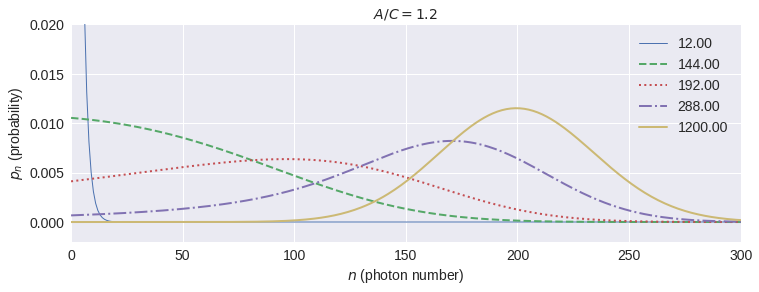

In [10]:
plot_photon_statistics_evolution(ls2, (1, 12, 16, 24, 100), \
                                 r'$A/C=1.2$', 0, 300, -0.002, 0.02)

### $A/C = 5$

In [11]:
laser_m = np.load('./data/vacu_200/200_vacu_l2.npz')
lm = laser_m['lasers'].flatten()[0]['5.00']

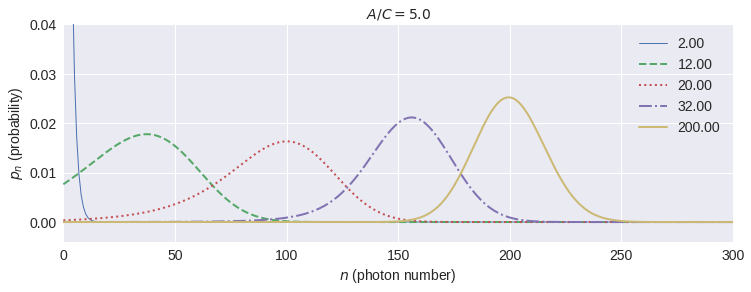

In [12]:
plot_photon_statistics_evolution(lm, (1, 6, 10, 16, 100), \
                                 r'$A/C=5.0$', 0, 300, -0.004, 0.04)

### $A/C = 64$

In [13]:
laser_l = np.load('./data/vacu_200/200_vacu_l3.npz')
ll = laser_l['lasers'].flatten()[0]['64.00']

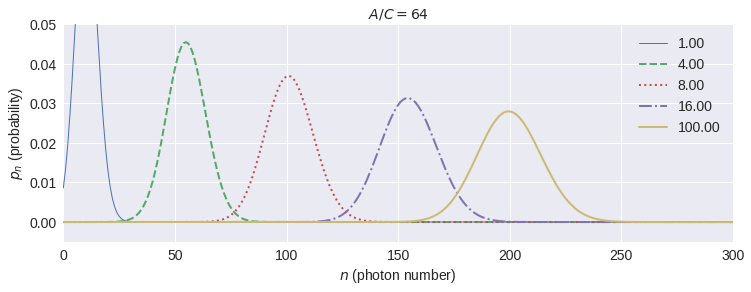

In [14]:
plot_photon_statistics_evolution(ll, (1, 4, 8, 16, 100), \
                                 r'$A/C=64$', 0, 300, -0.005, 0.05)

### Variance and Entropy

In [15]:
np.arange(10) / 0.5

array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.])

In [16]:
def calc_var_n(l, start, end):
    pns_all = l.get_pns()[start:end]
    var_n_all = []
    for pns in pns_all:
        aver_n = sum([pns[i] * i for i in range(N_max)])
        aver_n2 = sum([pns[i] * i**2 for i in range(N_max)])
        var_n_all.append(aver_n2 - aver_n**2)
    return np.array(var_n_all)


from scipy.special import erfc
def calc_entr_vec(mean, varn):
    """ Calculate the vector of entropy 
        given on the vector of the mean and the variance
    """
    result = np.log(np.sqrt(2.0 * np.pi * varn)) + 0.5
    result +=  np.log(0.5 * erfc(- mean / np.sqrt(2.0 * varn)))
    nn = - mean * np.exp(- mean**2 / 2.0 / varn) 
    dd = np.sqrt(2.0 * np.pi * varn) * erfc(- mean / np.sqrt(2.0 * varn))
    result += nn / dd
    reuslt = np.insert(result, 0, 0)
    return result

In [22]:
def plot_varn_entr(l, title, ax, start, end, approx=False):
    varn = calc_var_n(l, start, end)
    mean = l.get_ns()[start:end]
    if approx:
        entr = np.log(np.sqrt(2.0 * np.pi) * np.sqrt(varn)) + 0.5
    else:
        entr = calc_entr_vec(mean, varn)
    t_list = l.get_tlist()[start:end] * l.g
    
    ln, = ax.plot(t_list, entr, linestyle='--', label='Gaussian entropy')
    ax.plot(t_list, l.get_entrs()[start:end], linestyle='-', label ='numeric entropy')
    ax.plot(t_list, entr - l.get_entrs()[start:end], linestyle='-.', label ='difference')
    ax.legend(fontsize=14, loc=4)
    ax.set_title("Entropy for A/C = " + title)
    
    return ln


def plot_varn_entr_all(lasers, start, end, approx=False):
    fig, ax_array = plt.subplots(2, 2, figsize=(12, 8), sharey=True)
    ax = np.ravel(ax_array)
    i = 0
    for ratio, l in sorted(lasers.items()):
        plot_varn_entr(l, ratio, ax[i], start, end, approx)
        i += 1

## Approximation of entropy based on the mean and the variance of photon numbers

A Poisson distribution can be appproximates by a Gaussian distribution. For a Gaussain distribution with variance $\sigma^2 = A$, mean 0, and truancated at $R$, the entropy is given by
$$
S = \log \sqrt{2 \pi \sigma^2} + \frac{1}{2} + \log \left( \frac{1}{2} \mathrm{erfc} \frac{R}{\sqrt{2\sigma^2}} \right)
+ \frac{R \exp(- \frac{R^2}{2\sigma^2})}{\sqrt{2 \pi \sigma^2} ~ \mathrm{erfc} \frac{R}{\sigma^2}}
$$
When the laser is at the steady state, $\sigma^2 \approx \frac{A^2}{BC}$, and $R = \frac{A}{B} - \frac{A^2}{BC}$. Before the laser reach the steady state, the truncated position $R$ can be approximated by $- \bar{n}$. In the following figures, the mean $\bar{n}$ and variance $\sigma^2$ are calculated given on the photon statistics $p(n)$ numerically.

### Approximation using variance (keep first two terms)

In [18]:
laser_s = np.load('./data/vacu_200/200_vacu_l1.npz')['lasers'].flatten()[0]
laser_m = np.load('./data/vacu_200/200_vacu_l2.npz')['lasers'].flatten()[0]
laser_l = np.load('./data/vacu_200/200_vacu_l3.npz')['lasers'].flatten()[0]

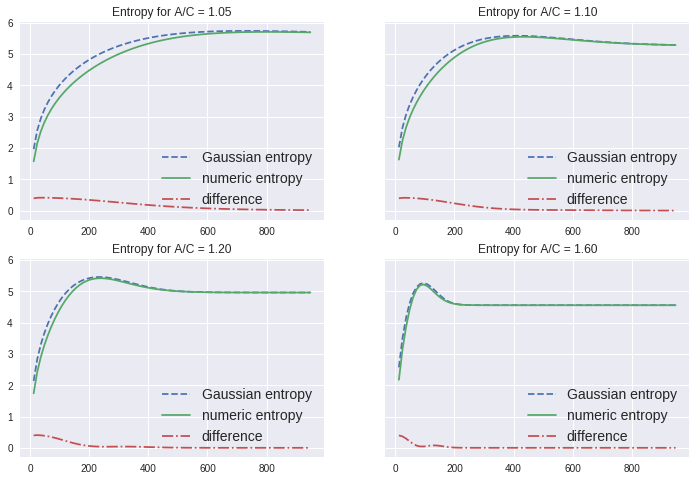

In [23]:
plot_varn_entr_all(laser_s, 1, 80, True)

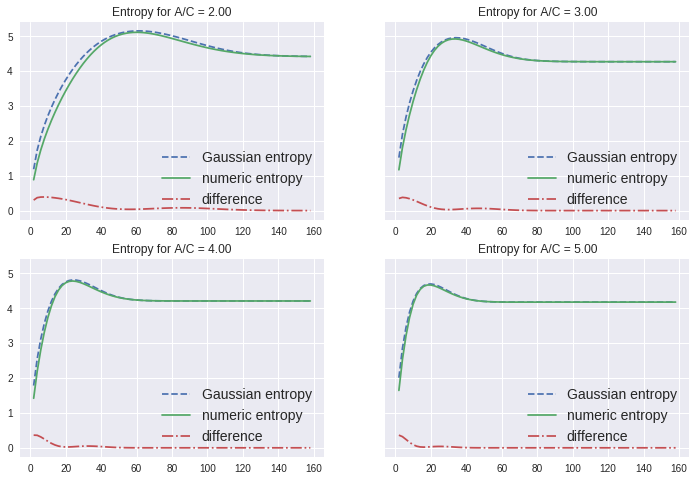

In [24]:
plot_varn_entr_all(laser_m, 1, 80, True)

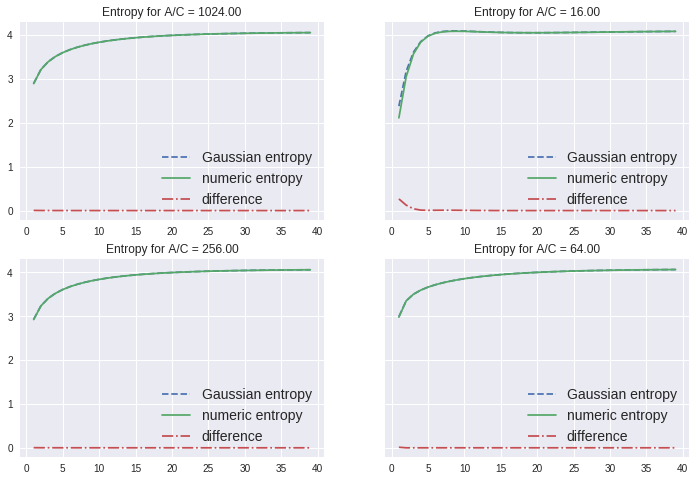

In [25]:
plot_varn_entr_all(laser_l, 1, 40, True)

### Approximation using variance and average

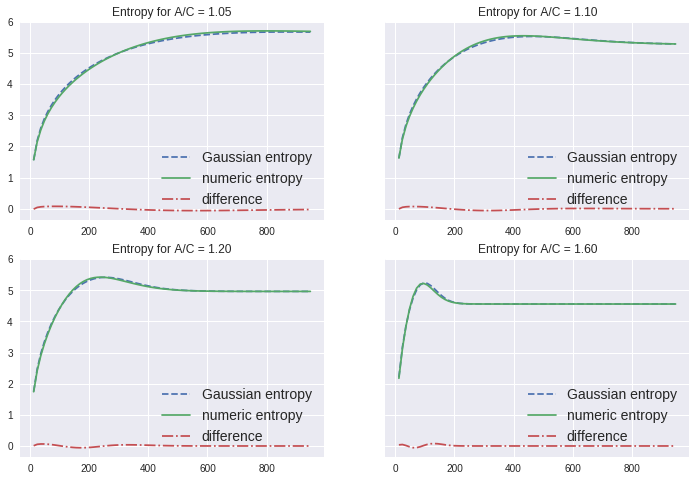

In [26]:
plot_varn_entr_all(laser_s, 1, 80)

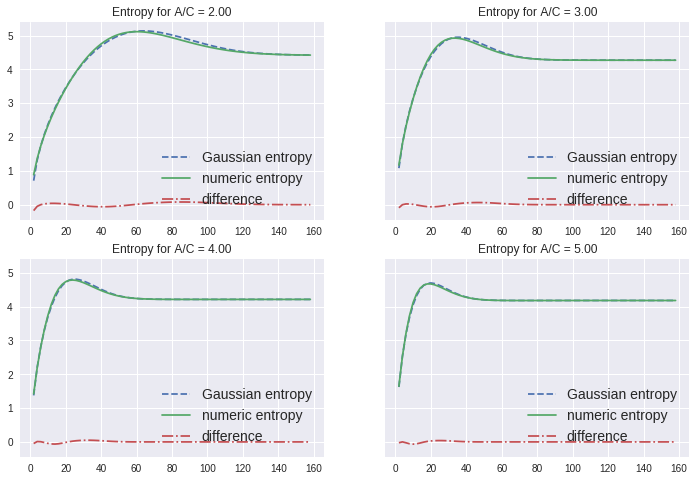

In [27]:
plot_varn_entr_all(laser_m, 1, 80)

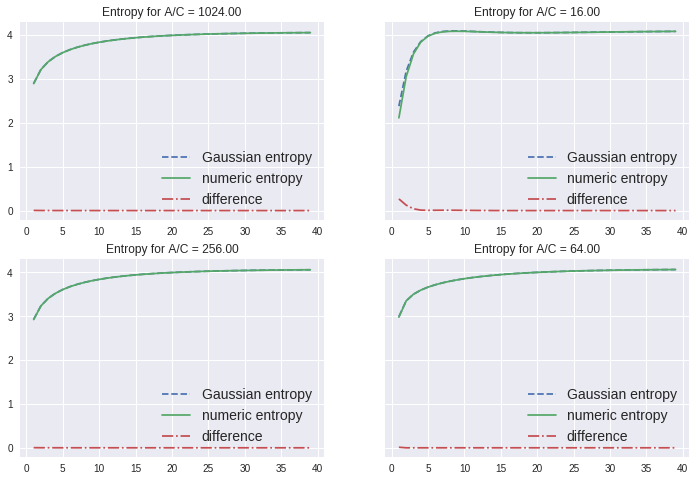

In [28]:
plot_varn_entr_all(laser_l, 1, 40, True)